In [32]:
import os
import sys
import torch as tf
import numpy as np
import matplotlib.pyplot as plt

# Magic trick from https://piazza.com/class/kyipdksfp9q1dn?cid=271_f1
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from tops.config import instantiate, LazyConfig
from ssd import utils
from tqdm import tqdm
from analyze_stuff import get_config, get_dataloader, analyze_something

In [33]:
config_path = "/home/viljamiu/SSD/configs/tdt4265.py"
cfg = get_config(config_path)
dataset_to_analyze = "train"  # or "val"
dataloader = get_dataloader(cfg, dataset_to_analyze)

It looks like you are currently working on the server, with a 'working directory' in: /work/snotra/viljamiu
	If you struggle with NTNU home directory becoming full, we recommend you to change the output directory to: /work/snotra/viljamiu
	 /work/snotra/viljamiu does not sync with NTNU HOME, and is a directory only located on the server.
	 To change the output directory of SSD, set save_in_work to True in the file configs/utils.py, in the function get_output_dir.
Saving SSD outputs to: outputs/
Found dataset directory in: /work/datasets/mnist_object_detection/train
Found dataset directory in: /work/datasets/mnist_object_detection/val
Found dataset directory in: /work/datasets/tdt4265_2022
Found dataset file in: /work/datasets/tdt4265_2022/train_annotations.json
Found dataset directory in: /work/datasets/tdt4265_2022
Found dataset file in: /work/datasets/tdt4265_2022/val_annotations.json


/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [34]:
# Print common info about the batches (which contain one image each)
batches = 0
for batch in dataloader:
    if batches == 1:
        break
    print("Labels are defined as: ", cfg.label_map)
    print("\nBatch is a dict with keys: ", list(batch.keys()))
    print("\nBatch[\"image\"] is a tensor with: ", batch["image"].shape)
    print("\nBox dimensions are [xmin ymin xmax ymax] (relative to size)")
    for key in list(batch.keys())[1:]:
        print("\nbatch[\"{}\"]:".format(key), batch[key])
    batches += 1

Labels are defined as:  {0: 'background', 1: 'car', 2: 'truck', 3: 'bus', 4: 'motorcycle', 5: 'bicycle', 6: 'scooter', 7: 'person', 8: 'rider'}

Batch is a dict with keys:  ['image', 'boxes', 'labels', 'width', 'height', 'image_id']

Batch["image"] is a tensor with:  torch.Size([1, 3, 128, 1024])

Box dimensions are [xmin ymin xmax ymax] (relative to size)

batch["boxes"]: tensor([[[0.4091, 0.5713, 0.4155, 0.7777],
         [0.4089, 0.6719, 0.4166, 0.7883],
         [0.4629, 0.5699, 0.4668, 0.6833],
         [0.7968, 0.5965, 0.8064, 0.8117],
         [0.0000, 0.5880, 0.0308, 1.0000],
         [0.0358, 0.5270, 0.0526, 0.6296],
         [0.2196, 0.6041, 0.2319, 0.9844],
         [0.0220, 0.5662, 0.0515, 0.8466],
         [0.4929, 0.6496, 0.5245, 1.0000],
         [0.5166, 0.5716, 0.5267, 0.6541],
         [0.5017, 0.5751, 0.5147, 0.6717],
         [0.9641, 0.4861, 0.9679, 0.6091],
         [0.8765, 0.5511, 0.8971, 0.7309],
         [0.8692, 0.5761, 0.8845, 0.7364],
         [0.8382, 0.59

## Visualize class label distribution in training set vs. validation set

In [35]:
def count_classes_per_image(dataloader):
    images = len(dataloader)
    classes = np.zeros(9)

    for image in dataloader:
        for label  in image["labels"].tolist()[0]:
            classes[label] += 1
        
    return (classes / images)

dataloader_train = dataloader
classes_train = count_classes_per_image(dataloader_train)

dataset_to_analyze = "val"
dataloader_val = get_dataloader(cfg, dataset_to_analyze)

classes_val = count_classes_per_image(dataloader_val)

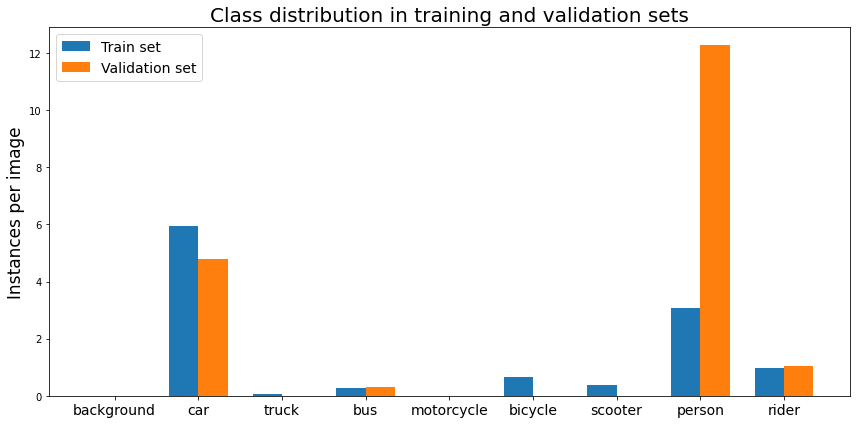

In [36]:
# Create the plot
x = np.arange(9)
width = 0.35
labels = list(cfg.label_map.values())

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.bar(x - width/2, classes_train, width, label='Train set')
ax.bar(x + width/2, classes_val, width, label='Validation set')

ax.set_ylabel('Instances per image',size=17)
ax.set_xticks(x)
ax.set_xticklabels(labels, size=14)
ax.legend(prop={'size': 14})
ax.set_title("Class distribution in training and validation sets", fontdict={"fontsize": 20})

fig.tight_layout()

plt.savefig('class_distribution_in_both_sets.pdf')

## Visualize bounding box sizes

In [37]:
def count_box_area_distribution(dataloader):
    areas = np.array([])

    for image in dataloader:
        boxes = image["boxes"][0].tolist()
        
        average = np.array([])
        
        for box in boxes:
            # box == [xmin ymin xmax ymax]
            w = (box[2]-box[0])*1024
            h = (box[3]-box[1])*128
            area = w*h
            average = np.append(average, area)
            
        areas = np.append(areas, np.mean(average))
        
    return (areas)

box_areas_train = count_box_area_distribution(dataloader_train)
box_areas_val = count_box_area_distribution(dataloader_val)

/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


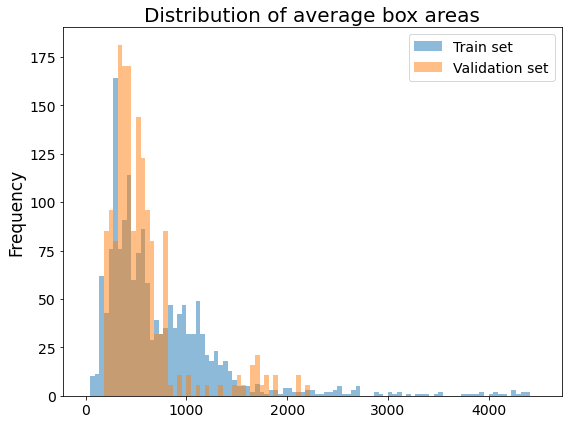

In [38]:
images_train = len(dataloader_train)
images_val = len(dataloader_val)
val_multiplier = images_train / images_val

start = 0
end = 4500
n = 100

bins_all = np.linspace(start, end, n)

counts_train, bins_train = np.histogram(box_areas_train, bins=n, range=(start, end))
counts_val, bins_val = np.histogram(box_areas_val, bins=n, range=(start, end))

plt.figure(figsize=(8, 6))

plt.hist(bins_all, bins_all, alpha=0.5, weights=counts_train, label='Train set')
plt.hist(bins_all, bins_all, alpha=0.5, weights=val_multiplier*counts_val, label='Validation set')
plt.ylabel('Frequency',size=17)
plt.legend(prop={'size': 14})
plt.title("Distribution of average box areas", fontdict={"fontsize": 20})
plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()
plt.savefig("average_box_area_distribution.pdf")

## Visualize person and car class bounding box distributions
### for areas and aspect ratios

In [39]:
# {0: 'background', 1: 'car', 2: 'truck', 3: 'bus', 4: 'motorcycle',
# 5: 'bicycle', 6: 'scooter', 7: 'person', 8: 'rider'}
def count_car_and_person_stats(dataloader):
    car = 1
    person = 7

    car_areas = np.array([])
    car_aspects = np.array([])
    person_areas = np.array([])
    person_aspects = np.array([])

    for image in dataloader_train:
        labels = image["labels"][0].tolist()
        boxes = image["boxes"][0].tolist()

        for i, label in enumerate(labels):
            box = boxes[i]
            w = (box[2]-box[0])*1024
            h = (box[3]-box[1])*128
            area = w*h
            aspect = w/h
            if label == car:
                car_areas = np.append(car_areas, area)
                car_aspects = np.append(car_aspects, aspect)
            if label == person:
                person_areas = np.append(person_areas, area)
                person_aspects = np.append(person_aspects, aspect)
                
    return(car_areas, car_aspects, person_areas, person_aspects)

c_ar, c_as, p_ar, p_as = count_car_and_person_stats(dataloader_train)
c_ar2, c_as2, p_ar2, p_as2 = count_car_and_person_stats(dataloader_val)

car_areas = np.concatenate((c_ar, c_ar2))
car_aspects = np.concatenate((c_as, c_as2))
person_areas = np.concatenate((p_ar, p_ar2))
person_aspects = np.concatenate((p_as, p_as2))

/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


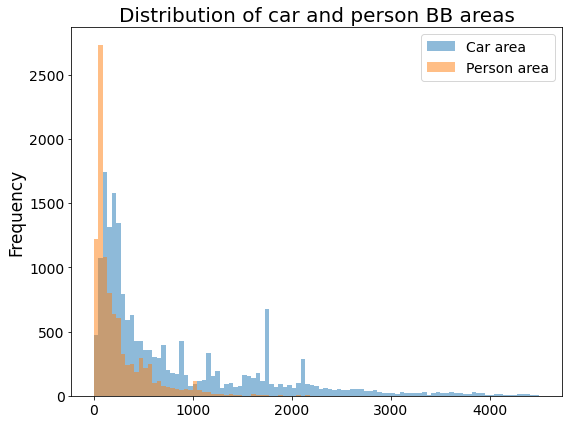

In [42]:
# Plot areas of bounding boxes
start = 0
end = 4500
n = 100

bins = np.linspace(start, end, n)

plt.figure(figsize=(8, 6))

plt.hist(car_areas, bins, alpha=0.5, label='Car area')
plt.hist(person_areas, bins, alpha=0.5, label='Person area')
plt.ylabel('Frequency',size=17)
plt.legend(prop={'size': 14})
plt.title("Distribution of car and person BB areas", fontdict={"fontsize": 20})
plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()
plt.savefig("car_person_bb_areas.pdf")

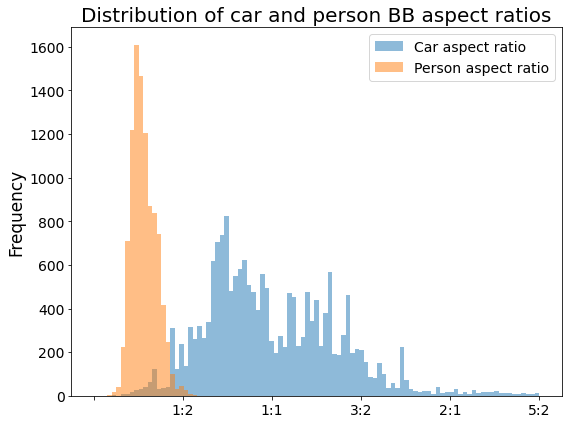

In [43]:
# Plot aspect ratios of bounding boxes
start = 0
end = 2.5
n = 100

bins = np.linspace(start, end, n)

plt.figure(figsize=(8, 6))

plt.hist(car_aspects, bins, alpha=0.5, label='Car aspect ratio')
plt.hist(person_aspects, bins, alpha=0.5, label='Person aspect ratio')
plt.ylabel('Frequency',size=17)
plt.legend(prop={'size': 14})
plt.title("Distribution of car and person BB aspect ratios", fontdict={"fontsize": 20})
plt.xticks([0, 0.5, 1, 1.5, 2, 2.5],
       ['', '1:2', '1:1', '3:2', '2:1', '5:2'], size=14)
plt.yticks(size=14)
plt.tight_layout()
plt.savefig("car_person_bb_aspect_ratios.pdf")